<a href="https://colab.research.google.com/github/pachterlab/monod_examples/blob/main/Monod_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Monod* on Colab

In the current notebook, we apply *Monod* to identify differentially regulated genes between GABAergic and glutamatergic cell types in a single Allen dataset. 

# Inference pipeline

## Define aesthetics

In [ ]:
import time
t1 = time.time()
#a e s t h e t i c s

fs = 16
nbin=40

#https://github.com/BlakeRMills/MetBrewer
Degas=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29")
Demuth = ("#591c19", "#9b332b", "#b64f32", "#d39a2d", "#f7c267", "#b9b9b8", "#8b8b99", "#5d6174", "#41485f", "#262d42")


## Install prerequisites

In [ ]:
%%capture
!pip install -i https://test.pypi.org/simple/ -U --extra-index-url https://pypi.org/simple   monod  
# !pip install -i https://pypi.org/simple/  monod  

Let's make sure that the version is correct.

In [ ]:
!pip show monod

Name: monod
Version: 0.2.2.4
Summary: The Monod package fits CME models to sequencing data.
Home-page: https://github.com/pachterlab/monod
Author: Gennady Gorin, Lior Pachter
Author-email: ggorin@caltech.edu, lpachter@caltech.edu
License: None
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, anndata, loompy, numpy, numdifftools, pytz
Required-by: 


## Import data

In [ ]:
! git clone https://github.com/pachterlab/monod_examples.git

Cloning into 'monod_examples'...
remote: Enumerating objects: 477, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 477 (delta 42), reused 145 (delta 41), pack-reused 331
Receiving objects: 100% (477/477), 455.10 MiB | 25.21 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [ ]:
!rm -r sample_data

In [ ]:
!mv monod_examples/* .

In [ ]:
!mv sample_data/* .

In [ ]:
!tar -xzvf allen_C01_gaba.tar.gz

allen_C01_gaba.loom


In [ ]:
!cat allen_C01_glu.tar.gz.001 allen_C01_glu.tar.gz.002 | tar -xzv

allen_C01_glu.loom


We can construct an `anndata` object with `spliced` and `unspliced` layers, in line with standard workflows.

In [ ]:
import anndata as ad

In [ ]:
a = ad.read_loom('allen_C01_glu.loom')
a.write('allen_C01_glu.h5ad')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
b = ad.read_loom('allen_C01_gaba.loom')
b.write('allen_C01_gaba.h5ad')

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Import package components

In [ ]:
import monod

In [ ]:
from monod import *
from monod.preprocess import *
from monod.extract_data import *
from monod.cme_toolbox import CMEModel
from monod.inference import InferenceParameters, GradientInference
from monod.analysis import *

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## Define metadata

In [ ]:
dataset_names = ['allen_C01_gaba','allen_C01_glu'] 
loom_filepaths = ['./'+x+'.h5ad' for x in dataset_names] 

transcriptome_filepath = './polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=['spliced','unspliced','gene_name','barcode']

In [ ]:
!mkdir fits

## Run pre-processing

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_220604_022_mouse_1 created.
INFO:root:Dataset: allen_C01_gaba
INFO:root:1704 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6284 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220604_022_mouse_1/allen_C01_gaba created.
INFO:root:Dataset: allen_C01_glu
INFO:root:4674 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7049 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220604_022_mouse_1/allen_C01_glu created.
INFO:root:Gene set size: 5810
INFO:root:250 genes selected.
INFO:root:Directory ./fits/gg_220604_022_mouse_1/diagnostic_figures created.


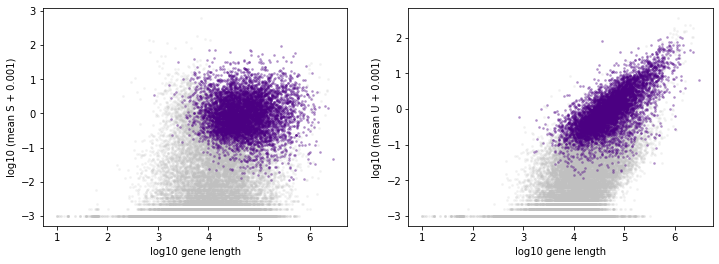

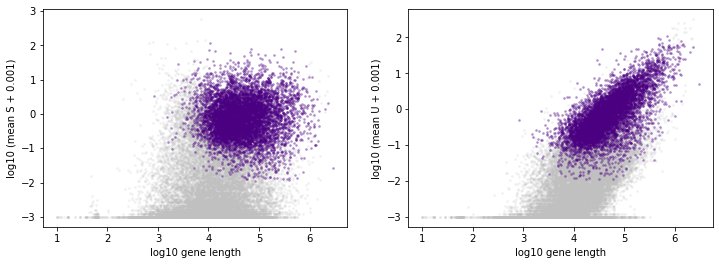

In [ ]:
dir_string,dataset_strings = construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='mouse',batch_id=1,\
                                             n_genes=250)

## Run inference

In this example, we will fit the bursty and constitutive models to all four datasets, using a Poisson sampling model on a $6\times 7$ grid. For this Colaboratory notebook, we only use 4 iterations from the MoM estimate.

INFO:root:Global inference parameters stored to ./fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_C01_gaba
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220604_022_mouse_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_220604_022_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Starting parallelized grid scan.


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures created.
INFO:root:Runtime: 1157.0 seconds.
INFO:root:Directory ./fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7 created.
INFO:root:Global inference parameters stored to ./fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_C01_glu
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220604_022_mouse_1/genes.csv.
INFO:root:Directory ./fits/gg_220604_022_mouse_1/allen_C01_glu/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_220604_022_mouse_1/allen_C01_glu/raw.sd.
INFO:root:Starting parallelized grid scan.


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures created.
INFO:root:Runtime: 658.5 seconds.


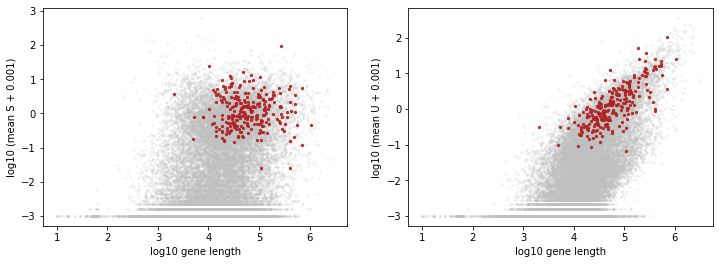

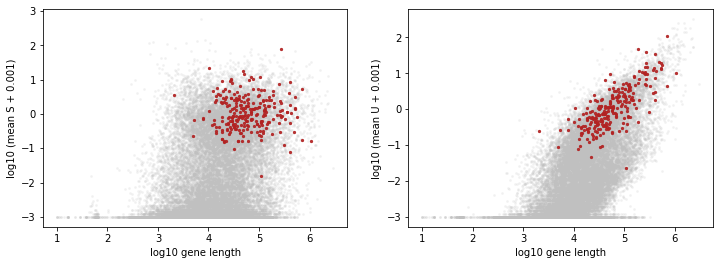

In [ ]:
n_datasets = len(dataset_names)
lb = [-1.0, -1.8, -1.8 ]
ub = [4.2, 2.5, 3.5]
grid = [6,7]

result_strings = []
for i in range(n_datasets):
    fitmodel = CMEModel('Bursty','Poisson')
    inference_parameters = InferenceParameters(lb,ub,[-8, -3],[-5, 0],grid,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})
    search_data = extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                        dataset_strings[i], dir_string, dataset_attr_names=attribute_names)
    full_result_string = inference_parameters.fit_all_grid_points(2,search_data)
    result_strings.append(full_result_string)


In [ ]:
%%capture
!tar -czvf sample_fits.tar.gz fits

# Analysis

## Post-processing and QC

Load in search data.

In [ ]:
sd_arr = [load_search_data(x+'/raw.sd') for x in dataset_strings]

INFO:root:Search data loaded from ./fits/gg_220604_022_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220604_022_mouse_1/allen_C01_glu/raw.sd.


Inspect all bursty result files and perform basic QC. We would like to be confident of the typical results:

*   The fits successfully recapitulate the joint count distributions
*   The sampling parameters appear to have a single unique optimum in $\{C_u, \lambda_s\}$
*   The physical parameters $\{b,\beta,\gamma\}$ are largely independent of gene length
*   The physical parameter distributions are consistent with a normal-inverse Gaussian law

In [ ]:
sr_arr = []
j=0

INFO:root:Grid scan results loaded from ./fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 5 genes out of 250. Runtime: 1.1 seconds.


/usr/local/lib/python3.7/dist-packages/monod/inference.py:582: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if gene_filter.dtype != np.bool:


INFO:root:Figure stored to ./fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 5 genes out of 250. Runtime: 1.6 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 5 genes out of 250. Runtime: 1.4 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 5 genes out of 250. Runtime: 1.6 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 5 genes out of 250. Runtime: 1.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 5 genes out of 250. Runtime: 0.9 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Re

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:3857: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:3857: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)


INFO:root:Figure stored to ./fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/parameter_marginals.png.


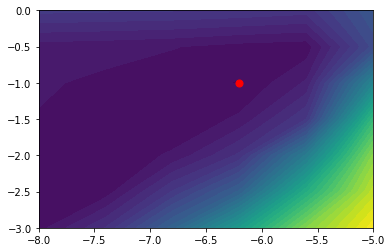

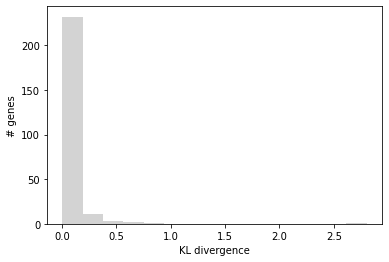

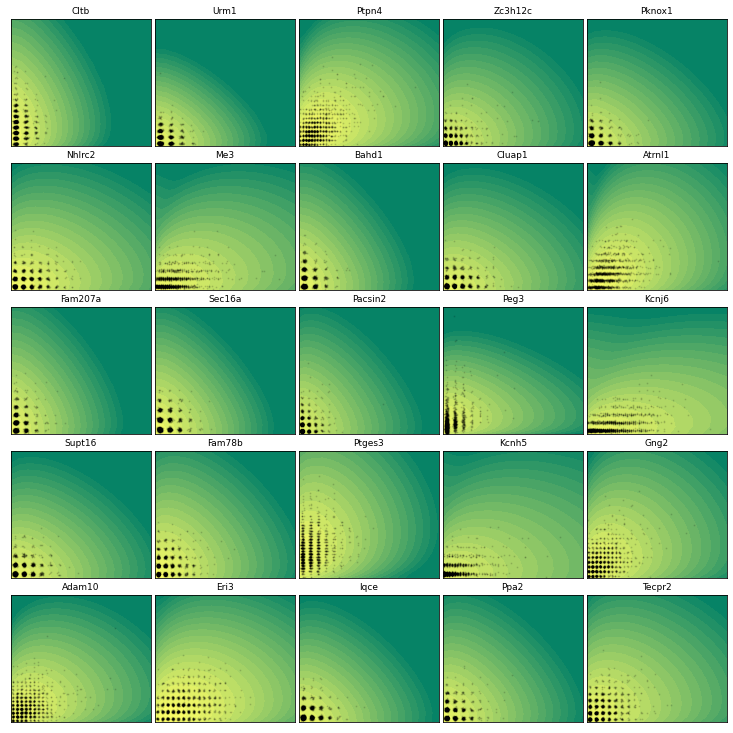

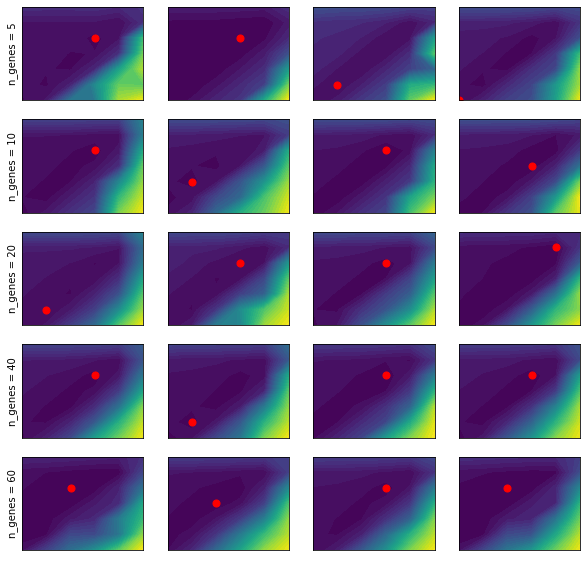

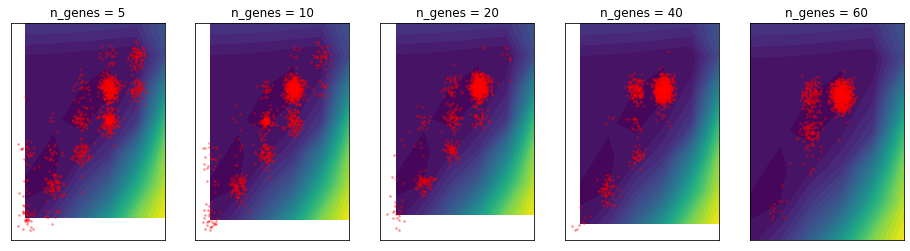

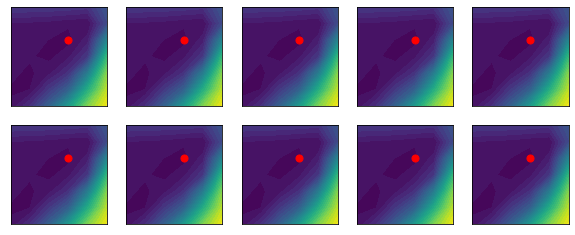

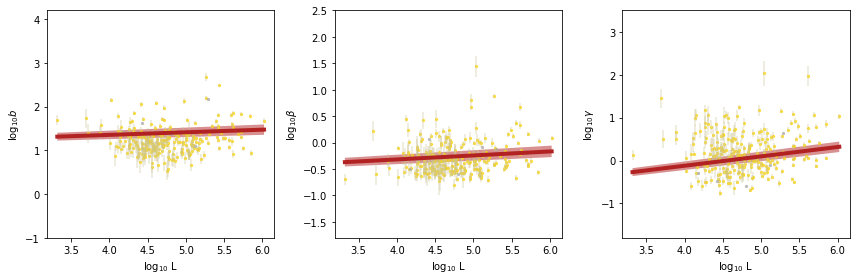

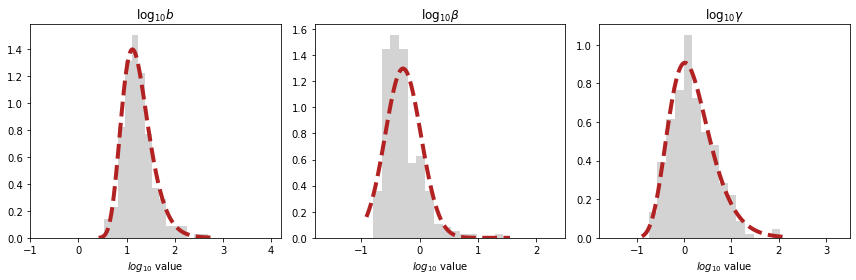

In [ ]:
sr = load_search_results(result_strings[j])
sd = sd_arr[j]
fig1,ax1 = plt.subplots(1,1)
sr.find_sampling_optimum()
sr.plot_landscape(ax1)



fig1,ax1 = plt.subplots(1,1)
sr.plot_KL(ax1)

sr.plot_gene_distributions(sd,marg='joint')

_=sr.chisquare_testing(sd)
sr.resample_opt_viz()
sr.resample_opt_mc_viz()
sr.chisq_best_param_correction(sd,viz=True) 

sr.compute_sigma(sd,num_cores=2)
sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
sr.plot_param_marg()
make_batch_analysis_dir([sr],dir_string)
sr.update_on_disk()
sr_arr.append(sr)

j+=1


INFO:root:Grid scan results loaded from ./fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


INFO:root:Chi-square computation complete. Rejected 10 genes out of 250. Runtime: 0.4 seconds.


/usr/local/lib/python3.7/dist-packages/monod/inference.py:582: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if gene_filter.dtype != np.bool:


INFO:root:Figure stored to ./fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 10 genes out of 250. Runtime: 0.4 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 10 genes out of 250. Runtime: 0.4 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 10 genes out of 250. Runtime: 0.4 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 10 genes out of 250. Runtime: 0.4 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 10 genes out of 250. Runtime: 0.4 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete.

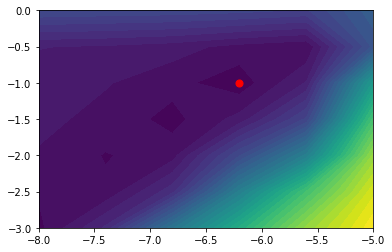

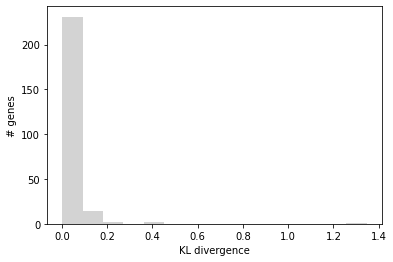

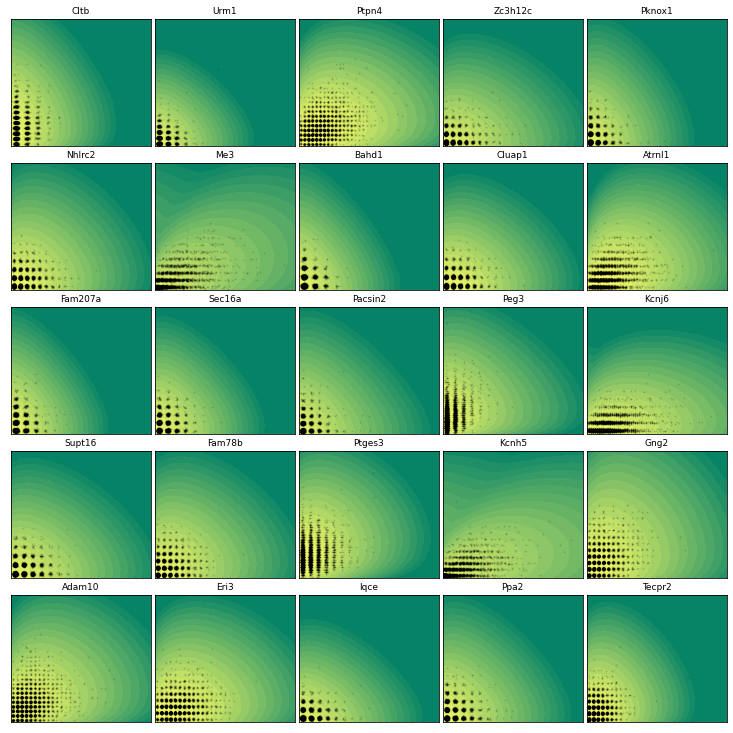

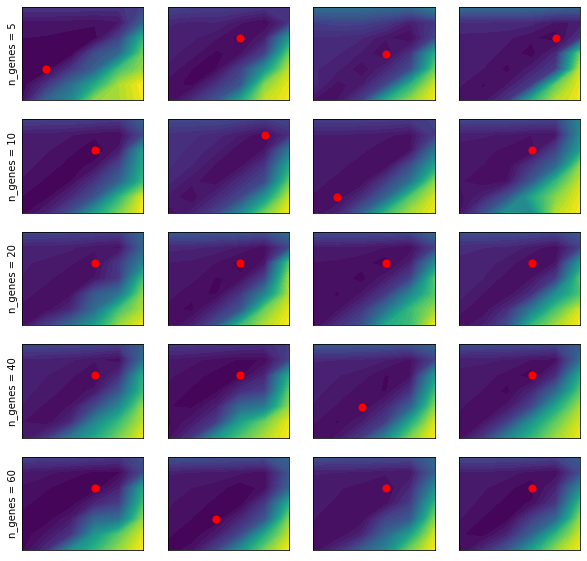

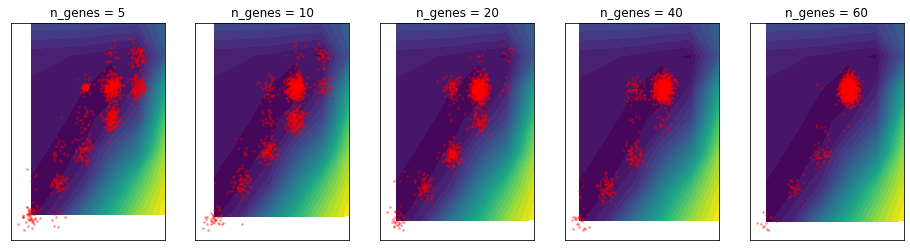

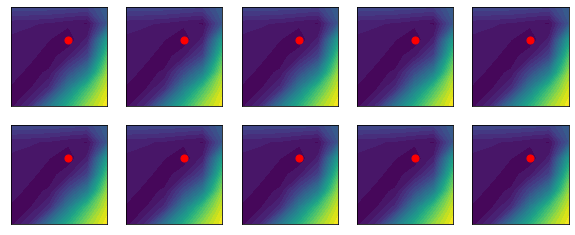

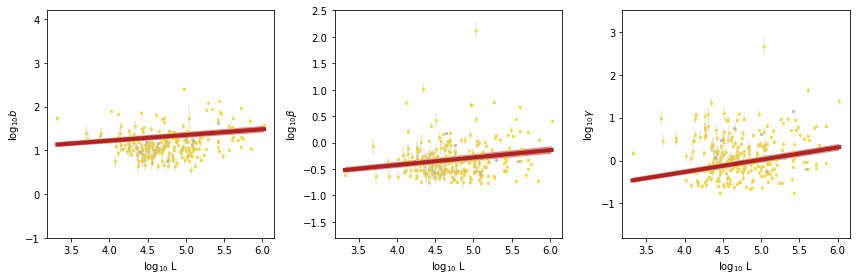

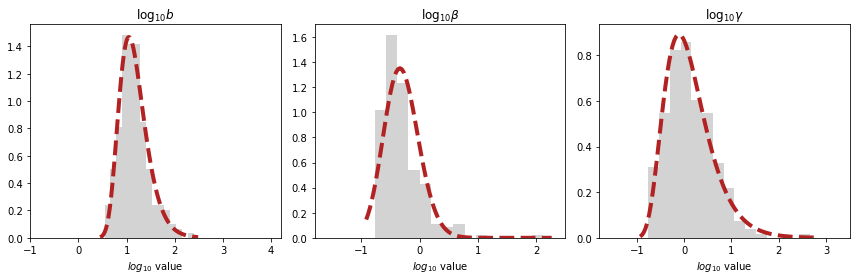

In [ ]:
sr = load_search_results(result_strings[j])
sd = sd_arr[j]
fig1,ax1 = plt.subplots(1,1)
sr.find_sampling_optimum()
sr.plot_landscape(ax1)



fig1,ax1 = plt.subplots(1,1)
sr.plot_KL(ax1)

sr.plot_gene_distributions(sd,marg='joint')

_=sr.chisquare_testing(sd)
sr.resample_opt_viz()
sr.resample_opt_mc_viz()
sr.chisq_best_param_correction(sd,viz=True) 

sr.compute_sigma(sd,num_cores=2)
sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
sr.plot_param_marg()
make_batch_analysis_dir([sr],dir_string)
sr.update_on_disk()
sr_arr.append(sr)


# Analysis of differential expression and regulation.

Uncomment these if you would like to use pre-computed sample results.

In [ ]:
# result_strings = ['./fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results_upd.res',
#  './fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results_upd.res']

In [ ]:
# dataset_strings = ['./fits/gg_220604_022_mouse_1/allen_C01_gaba',
#  './fits/gg_220604_022_mouse_1/allen_C01_glu']


Finally, we can analyze the four mouse datasets in terms of differences between their mRNA copy number distribution, potentially suggest differential regulation of their transcriptional processes.

In [ ]:
sr_arr = [load_search_data(x) for x in result_strings]

INFO:root:Search data loaded from ./fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results_upd.res.


In [ ]:
gn=sr_arr[0].gene_names
param_names = sr_arr[0].model.get_log_name_str()
n_phys_pars = sr_arr[0].sp.n_phys_pars
n_genes = sr_arr[0].n_genes
param_names_text = ('log10 b','log10 beta','log10 gamma','log10 ki')
n_genes = sd_arr[0].n_genes
pval_thr = 0.1

## Differential expression

The means are very similar between the datasets.

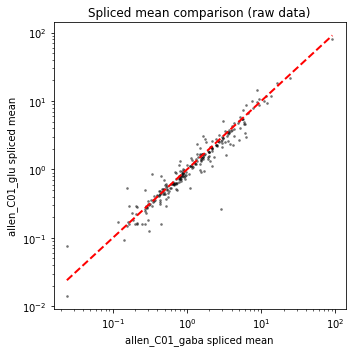

In [ ]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
m1 = np.asarray([sd_arr[0].moments[x]['S_mean']  for x in range(n_genes)])
m2 = np.asarray([sd_arr[1].moments[x]['S_mean'] for x in range(n_genes)])
ax1.scatter(m1,m2,3,'k',alpha=0.4)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(dataset_names[0] + ' spliced mean')
ax1.set_ylabel(dataset_names[1] + ' spliced mean')
ax1.set_title('Spliced mean comparison (raw data)')
xl = [min(m1),max(m1)]
ax1.plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

Raw means show changes of up to an order of magnitude.

In [ ]:
print((m1/m2).min())
print((m1/m2).max())

0.28643084
10.60889


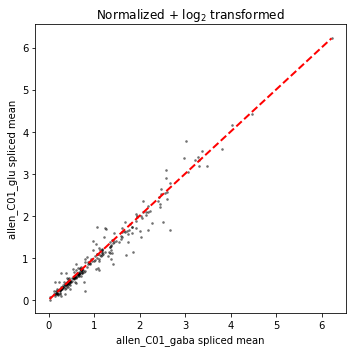

In [ ]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
m1norm = normalize_count_matrix(sd_arr[0].S,logbase=2).mean(1)
m2norm = normalize_count_matrix(sd_arr[1].S,logbase=2).mean(1)
ax1.scatter(m1norm,m2norm,3,'k',alpha=0.4)
ax1.set_xlabel(dataset_names[0] + ' spliced mean')
ax1.set_ylabel(dataset_names[1] + ' spliced mean')
ax1.set_title('Normalized + $\log_2$ transformed')
xl = [min(m1norm),max(m1norm)]
ax1.plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

The differences between means of normalized data are very small, less than a twofold change. Note we subtract here, because we have applied a $\log_2$ transformation to the raw data. 

In [ ]:
print((m1norm-m2norm).min())
print((m1norm-m2norm).max())

-0.7504535
0.99815285


Accordingly, the $t$-test identifies nothing.

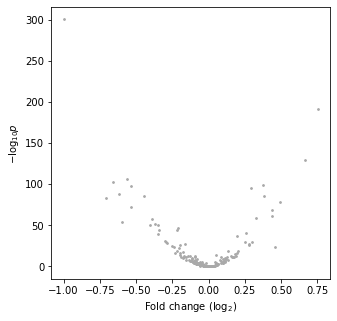

In [ ]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
gf_ttest,fc_ = compute_diffexp(sd_arr[0],sd_arr[1],lognormalize=True,viz=True,method='ttest',\
                                ax1=ax1,pval_thr=pval_thr,bonferroni=True)
fig_string = sr_arr[0].batch_analysis_string+'/ttest_s.png'
plt.savefig(fig_string,dpi=450)


## Differential regulation

Inspect the parameter trends. These are slightly less correlated than means.

INFO:root:Figure stored to ./fits/gg_220604_022_mouse_1/analysis_figures/pair_parameter_comparison_mouse.png.


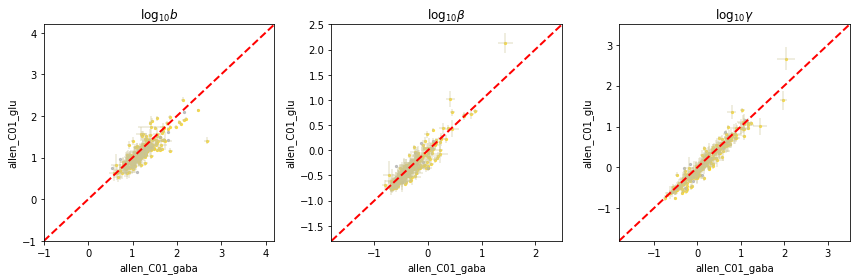

In [ ]:
plot_params_for_pair(sr_arr[0],sr_arr[1],\
                        distinguish_rej=True,plot_errorbars=True,meta = 'mouse',
                        xlabel = dataset_names[0],\
                        ylabel = dataset_names[1])

A handful of genes can be identified as outliers.

INFO:root:Figure stored to ./fits/gg_220604_022_mouse_1/analysis_figures/parameter_residuals_mouse.png.


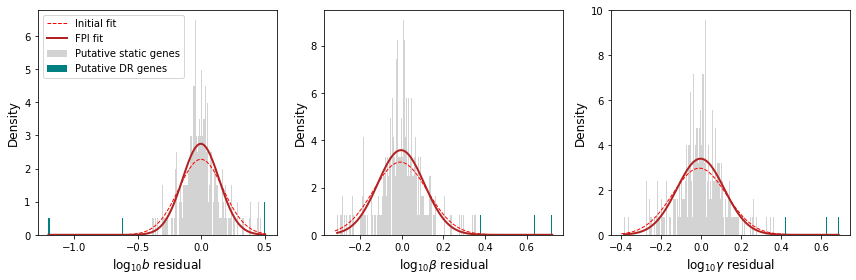

In [ ]:
dr_analysis = compute_diffreg(sr_arr[0],sr_arr[1],viz=True,modeltype='id',meta= 'mouse',use_sigma=True)

In [ ]:
dr_par = dr_analysis[1].T
fc_par = dr_analysis[3].T
dr_par = np.concatenate((dr_par,((dr_par[:,1] & dr_par[:,2]))[:,None]),1)
fc_par = np.concatenate((fc_par,(-(fc_par[:,1]+fc_par[:,2])/2)[:,None]),1)

What are these genes? 

In [ ]:
for k in range(n_phys_pars+1):
    print(param_names_text[k])
    print(gn[dr_par[:,k]])

log10 b
['Kcnh5' 'Grin3a' 'Tsnax' 'Nos1ap']
log10 beta
['Prom1' 'Cyp46a1' 'Lipg']
log10 gamma
['Gpc6' 'Prom1' 'Lipg']
log10 ki
['Prom1' 'Lipg']


We have identified *Prom1* and *Lipg* as frequency-modulated. Does this hypothesis hold more generally?

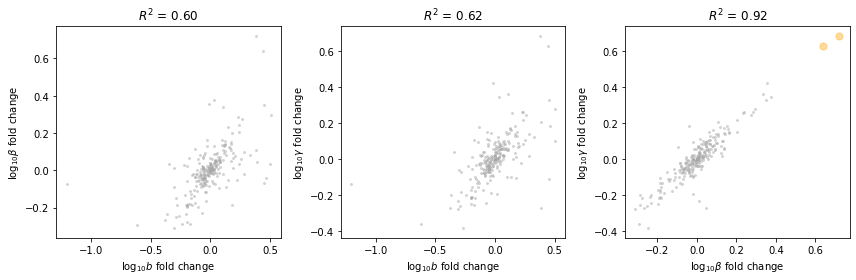

In [ ]:
pairs = [[0,1],[0,2],[1,2]]
q=0
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
q=0
for pair in pairs:
    k1 = pair[0]
    k2 = pair[1]
    gf = dr_par[:,k1] & dr_par[:,k2]

    x = fc_par[:,k1]
    y = fc_par[:,k2]
    x[np.isnan(x)] = 0 
    y[np.isnan(y)] = 0

    ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
    ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
    ax1[q].set_xlabel(param_names[k1]+' fold change')
    ax1[q].set_ylabel(param_names[k2]+' fold change')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(x,y)[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    q+=1
fig1.tight_layout()


## Raw data examination

### Burst size

Do the fit distributions actually match the data? First, consider those assigned to burst size modulation.

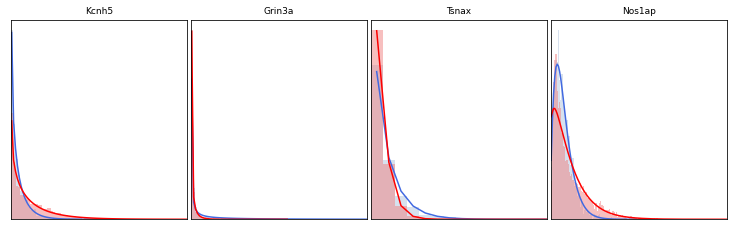

In [ ]:
gf = dr_par[:,0]
compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='nascent',logscale=False,sz=(1,4),figsize=(10,3))

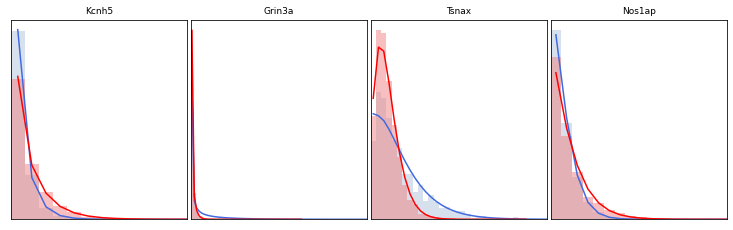

In [ ]:
compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='mature',logscale=False,sz=(1,4),figsize=(10,3))

They appear to match the data fairly well, altough *Tsnax* shows some subtle deviations in the mature mRNA distribution.

How much do the parameters change? The model predicts above 0.5 absolute $\log_2$ change.

In [ ]:
fc_par[gf][:,0]

array([ 0.50143858, -1.20509609, -0.61811646,  0.50395114])

How much do the means change? After normalization, less than 0.6.

In [ ]:
fc_[gf]

array([ 0.37511167, -0.5948716 , -0.53329706,  0.25244164], dtype=float32)

Raw averages do change more than twofold for *Grin3a*.

In [ ]:
(m1/m2)[gf]

array([ 0.39926505, 10.60889   ,  1.851147  ,  0.6057328 ], dtype=float32)

### Burst frequency

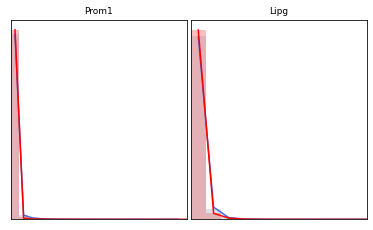

In [ ]:
gf = dr_par[:,3]
compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='nascent',logscale=False,sz=(1,2),figsize=(5,3))

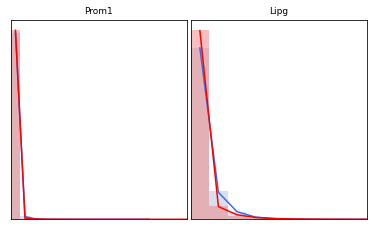

In [ ]:
compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='mature',logscale=False,sz=(1,2),figsize=(5,3))

The differences for frequency-modulated genes are more subtle. They predict approximately $\log_2$ fold change of -0.65 from GABAergic to glutamatergic.  The $\log_2$ fold change between averages after normalization is less than 0.1.

In [ ]:
fc_par[gf][:,3]

array([-0.70450135, -0.63331379])

In [ ]:
fc_[gf]

array([-0.01853234, -0.09296803], dtype=float32)

If we look at the difference between raw averages, it is less than twofold.

In [ ]:
(m1/m2)[gf]

array([1.7039586, 1.5611515], dtype=float32)

In [ ]:
!tar -czvf sample_fits.tar.gz fits

fits/
fits/gg_220604_022_mouse_1/
fits/gg_220604_022_mouse_1/allen_C01_gaba/
fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/
fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results.res
fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results_upd.res
fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/parameters.pr
fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/
fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/kldiv.png
fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/length_dependence.png
fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/chisquare_stability.png
fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling.png
fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png
fits/gg_220604_022_mouse_1/allen_C01_gaba/Bursty_